In [6]:
!mkdir /content/INS
!mkdir /content/vocal
!mkdir /content/mixed
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/content/INS’: File exists
mkdir: cannot create directory ‘/content/vocal’: File exists
mkdir: cannot create directory ‘/content/mixed’: File exists
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
!pip install youtube_dl
!pip install pydub

In [8]:
import os
import shutil
import zipfile
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
tk=tf.keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Conv2DTranspose
from keras.optimizers import SGD,Adam,RMSprop
from keras.layers.advanced_activations import LeakyReLU
import librosa
import librosa.display as ld
import IPython
import matplotlib.pyplot as plt
import youtube_dl
from pydub import AudioSegment
from pydub.playback import play
import kaggle

In [9]:
def y2be(l):
  ydl_opts = {
    'format': 'bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'mp3',
        'preferredquality': '192',
    }],
  }
  with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download(l)

In [10]:
l=['https://www.youtube.com/watch?v=DkGCvW0S5II']
y2be(l)

Deleting original file AR Rahman Instrumental Music Collection by VENKAT MEDISETTY-DkGCvW0S5II.webm (pass -k to keep)


In [11]:
def mixs(p1,p2,sv):
  sound1 = AudioSegment.from_mp3(p1)-30
  sound2 = AudioSegment.from_mp3(p2)
  output = sound1.overlay(sound2, position=0)
  output.export(sv, format="wav")

In [12]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

 99% 423M/429M [00:07<00:00, 102MB/s] 
100% 429M/429M [00:07<00:00, 60.1MB/s]


In [13]:
f=zipfile.ZipFile('/content/ravdess-emotional-speech-audio.zip')
f.extractall()

In [14]:
def vocalmp3(s=1,r=9):
  arr=None
  for i in range(s,r+1):
    path='/content/Actor_'
    if i<10:
      path+='0'+str(i)
      files=os.listdir(path)
      files=[i for i in files if i.endswith('.wav')]
      for i in files:
        fullpath=path+'/'+str(i)
        if not arr:
          arr=AudioSegment.from_wav(fullpath)
        else:
          arr=arr+AudioSegment.from_wav(fullpath)
    else:
      path+=(str(i))
      files=os.listdir(path)
      files=[i for i in files if i.endswith('.wav')]
      for i in files:
        fullpath=path+'/'+str(i)
        if not arr:
          arr=AudioSegment.from_wav(fullpath)
        else:
          arr=arr+AudioSegment.from_wav(fullpath)
    shutil.rmtree(path)
  arr.export('/content/vocals.mp3',format='mp3')

In [15]:
vocalmp3(1,24)

In [16]:
insaudio,sr=librosa.load('/content/instrumental.mp3')
vocaudio,sr=librosa.load('/content/vocals.mp3')

def save(aud,fname,dir,lngth,sr=sr):
  l=len(aud)
  for i in range(0,l,lngth):
    if i+lngth<l:
      t=aud[i:i+lngth]
      librosa.audio.sf.write(dir+'/'+fname+str(i)+'.wav',t,sr)

In [17]:
save(insaudio,'ins','/content/INS',(sr*2))
save(vocaudio,'voc','/content/vocal',(sr*2))

In [ ]:
def getData(train_size=0.85):
  ind=0
  df=pd.DataFrame(columns=['x','y'])
  inspath='/content/INS'
  vocpath='/content/vocal'
  insfiles=os.listdir(inspath)
  vocfiles=os.listdir(vocpath)
  for i in insfiles:
    fullpath=inspath+'/'+i
    a,sr=librosa.load(fullpath)
    df.loc[ind]=[a,0]
    ind+=1
  
  for i in vocfiles:
    fullpath=vocpath+'/'+i
    a,sr=librosa.load(fullpath)
    df.loc[ind]=[a,1]
    ind+=1
    rnd=np.random.choice(insfiles)
    mixs(inspath+'/'+rnd,fullpath,'/content/mixed/m'+str(ind)+'.wav')

  mxpath='/content/mixed'
  mxfiles=os.listdir('/content/mixed')
  for i in mxfiles:
    fullpath=mxpath+'/'+i
    if fullpath.endswith('.wav'):
      a,sr=librosa.load(fullpath)
      df.loc[ind]=[a,1]
      ind+=1
  df=df.sample(frac=1)
  df.loc[:,'x']=df.loc[:,'x'].apply(lambda x:librosa.stft(x,n_fft=1024,hop_length=256))

  msk=(np.random.rand(len(df))<=train_size)
  train,test=df[msk],df[~msk]
  train.reset_index()
  test.reset_index()

  def data_from_df(df_):
    l=len(df_)
    sh=([l]+list(df.iloc[0][0].shape))
    x=np.zeros(shape=sh,dtype=np.float32)
    y=np.zeros(shape=(l,1),dtype=np.int32)
    for i in range(l):
      x[i]=df.iloc[i][0]
      y[i][0]=df.iloc[i][1]
    return x,y


  return data_from_df(train),data_from_df(test)

In [ ]:
(xtrain,ytrain),(xtest,ytest)=getData()
xtrain=np.expand_dims(xtrain,axis=-1)
xtest=np.expand_dims(xtest,axis=-1)

In [18]:
def getData1(train_size=1):
  ind=0
  df=pd.DataFrame(columns=['x','y'])
  inspath='/content/INS'
  vocpath='/content/vocal'
  insfiles=os.listdir(inspath)
  vocfiles=os.listdir(vocpath)

  for i in insfiles:
    fullpath=inspath+'/'+i
    a,sr=librosa.load(fullpath)
    rnd=np.random.choice(vocfiles)
    mixs(fullpath,vocpath+'/'+rnd,'/content/mixed/m'+str(ind)+'.wav')
    b,sr=librosa.load('/content/mixed/m'+str(ind)+'.wav')
    df.loc[ind]=[b,librosa.load(vocpath+'/'+rnd)[0]]
    ind+=1

  df=df.sample(frac=1)
  df.loc[:,'x']=df.loc[:,'x'].apply(lambda x:librosa.stft(x,n_fft=1024,hop_length=256))
  df.loc[:,'y']=df.loc[:,'y'].apply(lambda x:librosa.stft(x,n_fft=1024,hop_length=256))

  def data_from_df(df_):
    l=len(df_)
    sh=([l]+list(df.iloc[0][0].shape))
    x=np.zeros(shape=sh,dtype=np.float32)
    y=np.zeros(shape=sh,dtype=np.float32)
    for i in range(l):
      x[i]=df.iloc[i][0]
      y[i]=df.iloc[i][1]
    return x,y


  return data_from_df(df),df


(X,Y),df=getData1()
X=np.expand_dims(X,axis=-1)
Y=np.expand_dims(Y,axis=-1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


In [19]:
model = Sequential()
model.add(Conv2D(16, (3,3), padding='same', input_shape=(X.shape[1],X.shape[2], X.shape[3])))
model.add(LeakyReLU())
model.add(Conv2D(16, (3,3), padding='same'))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))
model.add(Conv2D(16, (3,3), padding='same'))
model.add(LeakyReLU())
model.add(Conv2D(16, (3,3), padding='same'))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [20]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.001)
rms=RMSprop(lr=0.001)
model.compile(loss=keras.losses.binary_crossentropy, optimizer=adam, metrics=['accuracy'])

In [ ]:
model.fit(xtrain,ytrain,epochs=100,validation_data=(xtest,ytest))

In [ ]:
#model.save(filepath='/content/drive/MyDrive/Colab Notebooks/Models/vocal_act_detector.h5')
model.save(filepath='/content/drive/MyDrive/Colab Notebooks/Models/vocal_act_detector1.h5')

In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Models/vocal_act_detector.h5')

In [21]:
#model.trainable=0


inp=model.input
x=Conv2D(32, (3,3), padding='same',activation='relu')(model.layers[10].output)
x=LeakyReLU()(x)
x=MaxPooling2D(pool_size=(3,3))(x)
x=Dropout(0.25)(x)
x=Conv2D(64, (3,3), padding='same',activation='relu')(x)
x=LeakyReLU()(x)

x=MaxPooling2D(pool_size=(3,3))(x)
x=Dropout(0.25)(x)

x=Conv2D(128, (3,3), padding='same')(x)

x=Conv2DTranspose(64,(4,4),activation='relu',strides=(1,2))(x)
x=LeakyReLU()(x)
x=tk.layers.BatchNormalization()(x)


x=Conv2DTranspose(32,(4,4),activation='relu',strides=(2,2))(x)
x=LeakyReLU()(x)
x=tk.layers.BatchNormalization()(x)


x=Conv2DTranspose(32,(4,4),activation='relu',strides=(2,2))(x)
x=LeakyReLU()(x)
x=tk.layers.BatchNormalization()(x)


x=Conv2DTranspose(16,(4,4),activation='relu',strides=(3,3))(x)
x=LeakyReLU()(x)
x=tk.layers.BatchNormalization()(x)


x=Conv2DTranspose(16,(4,4),activation='relu',strides=(4,2))(x)
x=LeakyReLU()(x)
x=tk.layers.BatchNormalization()(x)


x=Conv2DTranspose(8,(4,4),activation='relu',strides=(1,1))(x)
x=LeakyReLU()(x)
x=tk.layers.BatchNormalization()(x)

x=Conv2DTranspose(1,(4,4),activation='relu',strides=(1,1))(x)

def lmd(tns):
  return tns[:,0:513,0:173,:]

out=tk.layers.Lambda(lmd)(x)

model1=tk.models.Model(inp,out)

In [ ]:
model1.summary()

In [33]:
def l(ytrue,ypred):
  return keras.losses.MAE(ytrue,ypred)
model1.compile(loss=l, optimizer=RMSprop(learning_rate=0.001))

In [ ]:
model1.fit(X,Y*10,epochs=500,batch_size=128)

In [123]:
model.save('/content/drive/MyDrive/Colab Notebooks/Models/vocal_extractor.h5')

In [ ]:
#prd=model1.predict(X)
while 1:
  i=np.random.randint(low=0,high=len(X)-1)
  p=prd[i,:,:,0]
  t=librosa.istft(p/10,hop_length=256)
  print(p.sum())
  if p.sum()!=0:
    break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Only one segment is calculated since parameter NFFT (=1024) >= signal length (=513).
  """Entry point for launching an IPython kernel.


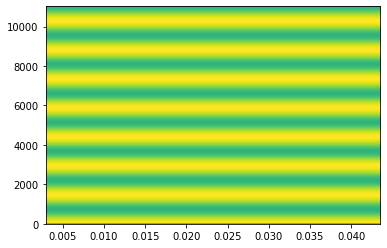

In [120]:
x=plt.specgram(p,NFFT=1024,Fs=sr)

In [121]:
IPython.display.Audio(t,rate=sr)

In [122]:
IPython.display.Audio(librosa.istft(X[i,:,:,0],hop_length=256),rate=sr)

In [124]:
model1.save('/content/drive/MyDrive/Colab Notebooks/Models/vocal_extractor.h5')